# Baseline PR Segmentor Analysis

This notebook provides a detailed analysis of each segmentation technique used in the baseline PR CAPTCHA detection pipeline. The baseline PR segmentor uses advanced color-aware segmentation techniques that are unique compared to standard approaches.

## Segmentation Pipeline Overview

The baseline PR segmentor employs the following segmentation strategies:

1. **Color-First Segmentation (LAB a/b)**: Uses LAB color space chroma channels (a/b) with Gaussian Mixture Model (GMM) clustering to segment characters by color
2. **BIC-Based Model Selection**: Automatically selects optimal number of clusters using Bayesian Information Criterion
3. **Edge-Constrained Validation**: Uses Canny edge detection to refine character boundaries
4. **Connected Components Fallback**: Falls back to traditional connected components analysis when color segmentation fails
5. **Line Removal and Cleaning**: Removes noise lines that interfere with segmentation

Each technique addresses specific challenges in CAPTCHA segmentation, particularly for multi-colored characters and complex backgrounds.


In [1]:
# Import required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from typing import List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load sample CAPTCHA images for analysis
data_dir = Path("../../data/main")
image_files = sorted(list(data_dir.glob("*.png")))[:10]  # Load first 10 for variety

sample_images = []
sample_labels = []

for img_path in image_files:
    img = cv2.imread(str(img_path))
    if img is not None:
        sample_images.append(img)
        sample_labels.append(img_path.stem)

print(f"Loaded {len(sample_images)} sample images")
print(f"Sample labels: {sample_labels[:5]}")


Loaded 10 sample images
Sample labels: ['0024miih-0', '002e23-0', '002k-0', '006aguv-0', '00fh-0']


In [3]:
# Import preprocessor for creating binary images
# (Simplified version for demonstration)
from skimage.filters import threshold_sauvola

class SimplePreprocessor:
    """Simplified preprocessor for creating binary images"""
    def _smart_grayscale(self, image):
        b, g, r = cv2.split(image)
        gray_standard = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        stds = [r.std(), g.std(), b.std(), gray_standard.std()]
        best_channel = [r, g, b, gray_standard][np.argmax(stds)]
        multi_channel_max = np.maximum(np.maximum(r, g), b)
        return np.maximum(best_channel, multi_channel_max)
    
    def _enhance_contrast(self, gray):
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        return clahe.apply(gray)
    
    def _adaptive_threshold(self, gray, block_size=15, C=2):
        return cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV, blockSize=block_size, C=C
        )
    
    def preprocess(self, image):
        gray = self._smart_grayscale(image)
        gray = self._enhance_contrast(gray)
        gray = cv2.equalizeHist(gray)
        _, binary_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        binary_adaptive = self._adaptive_threshold(gray, block_size=15, C=2)
        thresh_sauvola = threshold_sauvola(gray, window_size=25, k=0.2)
        binary_sauvola = (gray < thresh_sauvola).astype(np.uint8) * 255
        binary = cv2.bitwise_or(binary_otsu, binary_adaptive)
        binary = cv2.bitwise_or(binary, binary_sauvola)
        return binary

preprocessor = SimplePreprocessor()
print("Preprocessor initialized!")


Preprocessor initialized!


In [4]:
# Import the segmenter class from baseline_pr notebook
# This is the AdvancedCAPTCHASegmenter class with color segmentation

class AdvancedCAPTCHASegmenter:
    """Segmenter class with color-first segmentation from baseline_pr"""
    
    def __init__(self):
        self.failure_modes = {
            "touching_glyphs": 0,
            "over_segmentation": 0,
            "under_segmentation": 0,
            "watershed_fallback": 0,
            "segmentation_failures": 0,
            "color_segmentation_lab_ab": 0,
            "total_processed": 0,
        }

    def remove_black_lines(self, image: np.ndarray) -> np.ndarray:
        """Replace pixels that are close to black with white"""
        black_thresh = np.all(image < 5, axis=2)
        result = image.copy()
        result[black_thresh] = [255, 255, 255]
        return result

    def _segment_by_color_lab(
        self,
        original_image: np.ndarray,
        min_char_width: int,
        min_char_height: int,
        k_max: int = 9,
    ) -> List[Tuple[int, int, int, int]]:
        """
        Color-first segmentation using LAB chroma (a/b) with robust GMM selection
        """
        # Remove black lines first
        original_image = self.remove_black_lines(original_image)

        # 1) LAB a/b features as float64
        lab = cv2.cvtColor(original_image, cv2.COLOR_BGR2LAB)
        ab = lab[:, :, 1:3].reshape(-1, 2).astype(np.float64)

        # 2) Subsample for model selection
        n_pixels = ab.shape[0]
        sample = resample(
            ab, n_samples=min(4000, n_pixels), replace=False, random_state=42
        )

        # 3) Scale features
        scaler = StandardScaler(with_mean=True, with_std=True)
        sample_s = scaler.fit_transform(sample)
        ab_s = scaler.transform(ab)

        # 4) Guard against degenerate covariance
        n_samples = sample_s.shape[0]
        n_unique = np.unique(sample_s, axis=0).shape[0]
        k_upper = max(2, min(k_max, n_unique - 1, n_samples - 1))
        if n_unique < n_samples:
            sample_s = sample_s + 1e-6 * np.random.randn(*sample_s.shape)

        # 5) Select K by BIC
        best_gmm: Optional[GaussianMixture] = None
        best_bic: float = np.inf

        for k in range(2, k_upper + 1):
            tried = [("full", 1e-2), ("diag", 1e-2)]
            for covariance_type, reg_covar in tried:
                gmm = GaussianMixture(
                    n_components=k,
                    covariance_type=covariance_type,
                    reg_covar=reg_covar,
                    init_params="kmeans",
                    n_init=3,
                    max_iter=200,
                    random_state=42,
                )
                try:
                    gmm.fit(sample_s)
                    bic = gmm.bic(sample_s)
                except ValueError:
                    continue
                if bic < best_bic:
                    best_bic, best_gmm = bic, gmm

        if best_gmm is None:
            return []

        # 6) Assign all pixels
        labels = best_gmm.predict(ab_s).reshape(lab.shape[:2])

        # 7) Edge prior to anchor strokes
        gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 30, 100)
        edges = cv2.dilate(edges, np.ones((2, 2), np.uint8), iterations=1)

        H, W = gray.shape
        img_area = H * W
        max_area_px = int(0.3 * img_area)

        char_boxes: List[Tuple[int, int, int, int]] = []

        # 8) Per-cluster mask → edge-constrained refinement → CC → geometry validation
        for c in range(best_gmm.n_components):
            mask = (labels == c).astype(np.uint8) * 255
            mask = cv2.bitwise_or(mask, edges)

            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((2, 2), np.uint8))

            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                min_area_px = max(35, int(0.0022 * img_area))
                area = w * h
                if area > max_area_px or area < min_area_px:
                    continue
                ar = w / max(h, 1)
                if not (0.15 <= ar <= 3.0):
                    continue
                char_boxes.append((x, y, x + w, y + h))

        # 9) Simple left-to-right merge to deduplicate overlaps
        if len(char_boxes) > 1:
            char_boxes = sorted(char_boxes, key=lambda b: b[0])
            merged: List[Tuple[int, int, int, int]] = []
            for b in char_boxes:
                if not merged:
                    merged.append(b)
                    continue
                x1, y1, x2, y2 = b
                X1, Y1, X2, Y2 = merged[-1]
                inter_w = max(0, min(x2, X2) - max(x1, X1))
                inter_h = max(0, min(y2, Y2) - max(y1, Y1))
                inter = inter_w * inter_h
                a1 = (x2 - x1) * (y2 - y1)
                a2 = (X2 - X1) * (Y2 - Y1)
                if inter > 0.3 * min(a1, a2):
                    nx1, ny1 = min(x1, X1), min(y1, Y1)
                    nx2, ny2 = max(x2, X2), max(y2, Y2)
                    merged[-1] = (nx1, ny1, nx2, ny2)
                else:
                    merged.append(b)
            char_boxes = merged

        return char_boxes

    def _clean_image(self, binary_image: np.ndarray) -> np.ndarray:
        """Remove background lines"""
        h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
        detected_h_lines = cv2.morphologyEx(
            binary_image, cv2.MORPH_OPEN, h_kernel, iterations=1
        )
        cleaned = cv2.subtract(binary_image, detected_h_lines)

        v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
        detected_v_lines = cv2.morphologyEx(
            cleaned, cv2.MORPH_OPEN, v_kernel, iterations=1
        )
        cleaned = cv2.subtract(cleaned, detected_v_lines)

        noise_kernel = np.ones((2, 2), np.uint8)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, noise_kernel, iterations=1)

        return cleaned

    def _find_character_regions(
        self,
        binary_image: np.ndarray,
        min_width: int = 3,
        max_width: Optional[int] = None,
        min_height: int = 5,
    ) -> List[Tuple[int, int, int, int]]:
        """Find character regions on a binary image"""
        contours, _ = cv2.findContours(
            binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        char_boxes: List[Tuple[int, int, int, int]] = []
        img_height, img_width = binary_image.shape

        if max_width is None:
            max_width = img_width // 3

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            area = w * h

            min_area = max(35, img_height * img_width * 0.0022)
            max_area = img_height * img_width * 0.4

            if (
                w >= min_width
                and w <= max_width
                and h >= min_height
                and h <= int(img_height * 0.95)
                and area >= min_area
                and area <= max_area
            ):
                aspect_ratio = w / h if h > 0 else 0.0
                if 0.08 < aspect_ratio < 3.5:
                    region = binary_image[y : y + h, x : x + w]
                    on = np.sum(region > 0)
                    density = on / area if area > 0 else 0.0

                    if area < 50:
                        min_density = 0.05
                    elif area < 200:
                        min_density = 0.035
                    else:
                        min_density = 0.03

                    if density >= min_density:
                        char_boxes.append((x, y, x + w, y + h))

        return char_boxes

    def segment(
        self,
        binary_image: np.ndarray,
        original_image: np.ndarray,
        min_char_width: int = 5,
        min_char_height: int = 10,
    ) -> List[Tuple[int, int, int, int]]:
        """
        Advanced segmentation pipeline with color-first strategy and robust fallback
        """
        self.failure_modes["total_processed"] += 1

        # Try color segmentation first
        char_boxes = self._segment_by_color_lab(
            original_image, min_char_width, min_char_height
        )

        if len(char_boxes) > 0:
            self.failure_modes["color_segmentation_lab_ab"] += 1
            char_boxes = sorted(char_boxes, key=lambda b: b[0])
            return char_boxes

        # Fallback to binary segmentation
        if binary_image.max() <= 1:
            binary_image = (binary_image * 255).astype(np.uint8)

        cleaned = self._clean_image(binary_image)
        char_boxes = self._find_character_regions(
            cleaned, min_width=min_char_width, min_height=min_char_height
        )

        if len(char_boxes) == 0:
            char_boxes = self._find_character_regions(
                binary_image,
                min_width=max(1, min_char_width - 2),
                min_height=max(1, min_char_height - 3),
            )
            self.failure_modes["segmentation_failures"] += 1

        char_boxes = sorted(char_boxes, key=lambda b: b[0])
        return char_boxes

    def visualize_segmentation(
        self,
        original_image: np.ndarray,
        binary_image: np.ndarray,
        char_boxes: List[Tuple[int, int, int, int]],
        title: str = "Segmentation",
    ) -> None:
        """Visualize segmentation results"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        if len(original_image.shape) == 3:
            axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        else:
            axes[0].imshow(original_image, cmap="gray")
        axes[0].set_title("Original")
        axes[0].axis("off")

        axes[1].imshow(binary_image, cmap="gray")
        axes[1].set_title("Preprocessed")
        axes[1].axis("off")

        axes[2].imshow(binary_image, cmap="gray")
        axes[2].set_title(f"{title} ({len(char_boxes)} chars)")
        for x1, y1, x2, y2 in char_boxes:
            rect = Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=2,
                edgecolor="red",
                facecolor="none",
            )
            axes[2].add_patch(rect)
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

# Initialize segmenter
segmenter = AdvancedCAPTCHASegmenter()
print("Segmenter initialized!")


Segmenter initialized!


## Technique 1: LAB Color Space and Chroma Channels (a/b)

**Problem**: RGB color space is not perceptually uniform, making it difficult to segment characters by color. Characters in similar colors may appear very different in RGB space.

**Solution**: Convert to LAB color space and use the chroma channels (a and b) which represent color information independent of lightness. This provides better color-based segmentation.

**Improvement**: LAB a/b channels are perceptually uniform and better suited for color-based clustering, especially for multi-colored CAPTCHAs.


TECHNIQUE 1: LAB COLOR SPACE AND CHROMA CHANNELS

Example 1: 0024miih-0


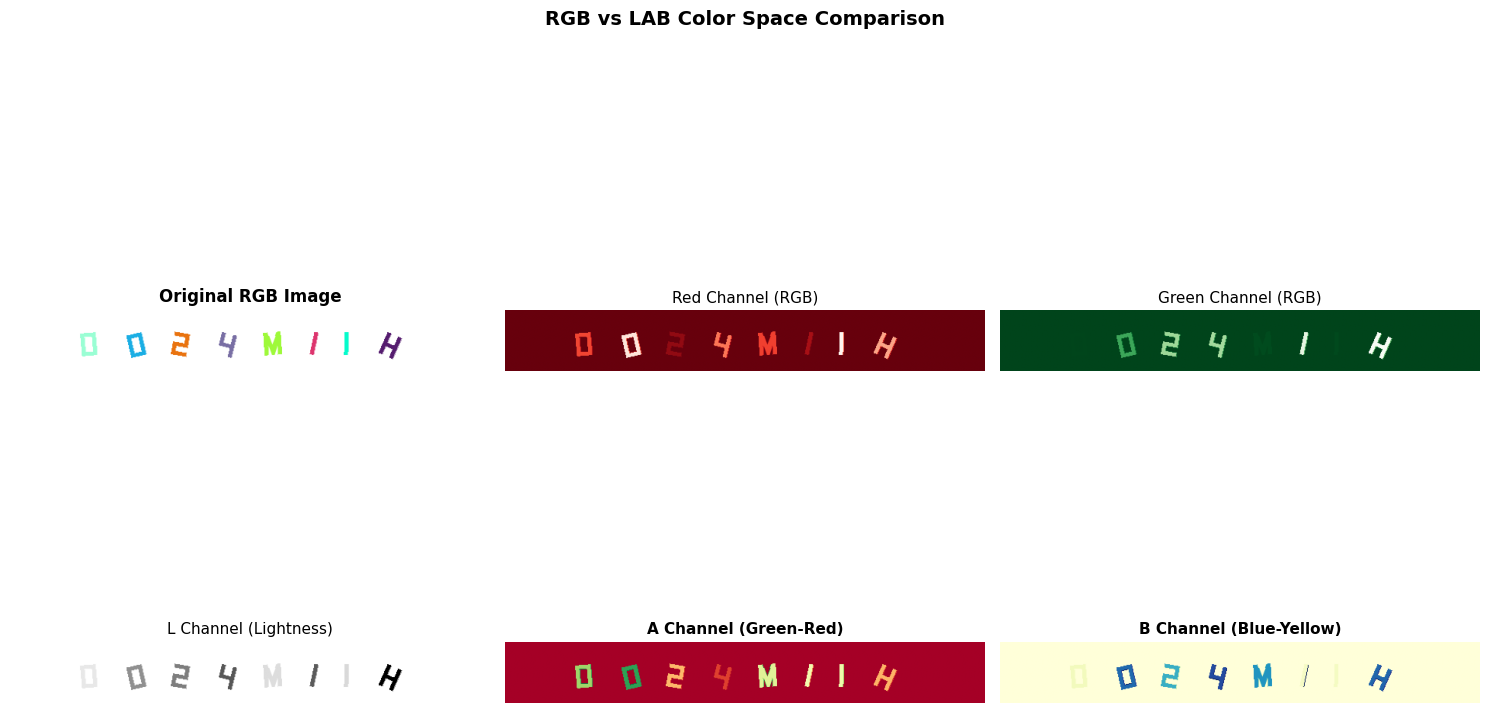

RGB channels - R: 32.7, G: 28.2, B: 32.9
LAB channels - L: 23.2, A: 9.8, B: 11.0
LAB a/b channels are used for color clustering (independent of lightness)

Example 2: 002e23-0


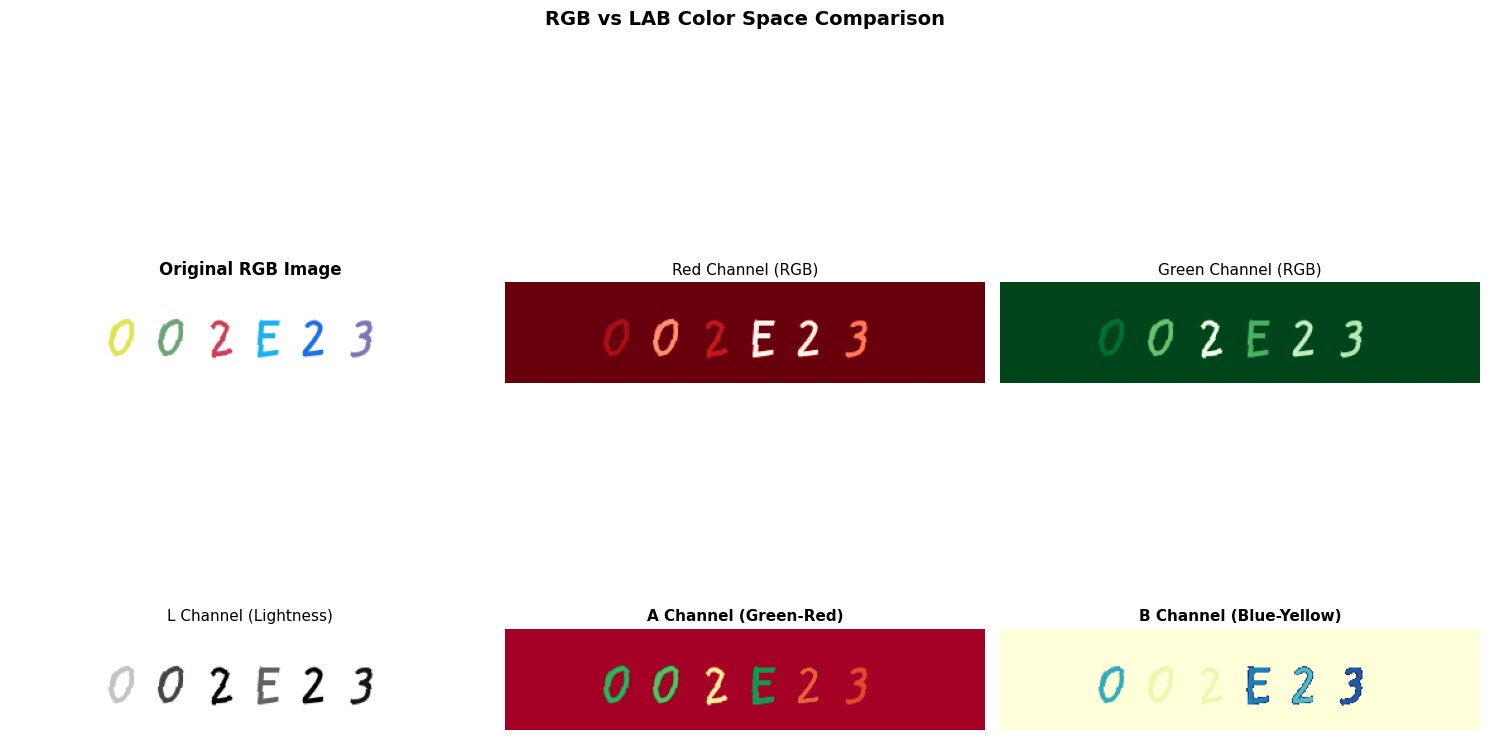

RGB channels - R: 30.8, G: 23.4, B: 23.6
LAB channels - L: 20.0, A: 5.8, B: 9.4
LAB a/b channels are used for color clustering (independent of lightness)

Example 3: 002k-0


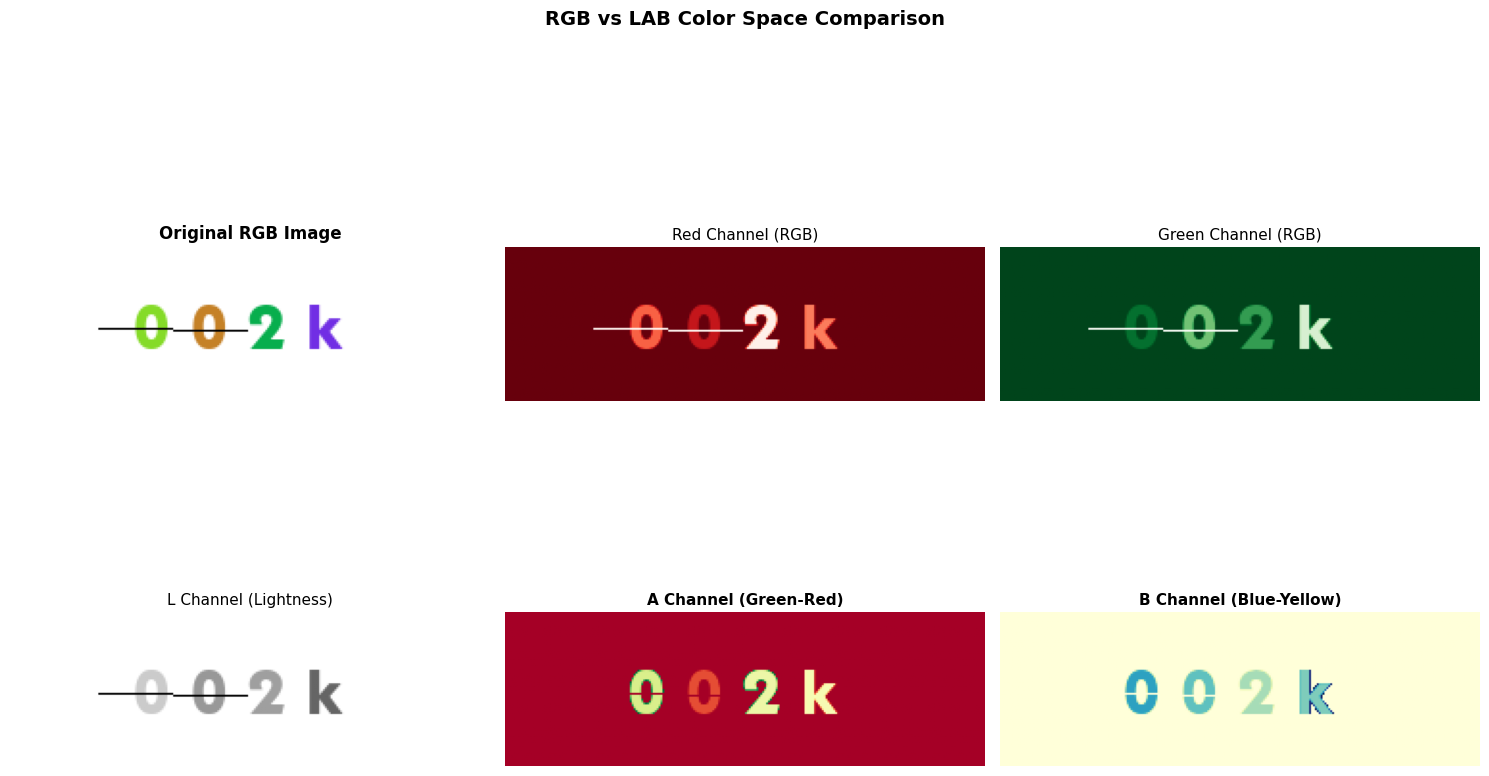

RGB channels - R: 36.2, G: 30.4, B: 39.9
LAB channels - L: 26.8, A: 10.9, B: 13.2
LAB a/b channels are used for color clustering (independent of lightness)



In [5]:
# Visualize LAB Color Space Conversion
def visualize_lab_colorspace(image):
    """Compare RGB vs LAB color space representation"""
    
    # Convert to LAB
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    
    # Get RGB channels for comparison
    b, g, r = cv2.split(image)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Row 1: RGB channels
    axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original RGB Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(r, cmap='Reds')
    axes[0, 1].set_title('Red Channel (RGB)', fontsize=11)
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(g, cmap='Greens')
    axes[0, 2].set_title('Green Channel (RGB)', fontsize=11)
    axes[0, 2].axis('off')
    
    # Row 2: LAB channels
    axes[1, 0].imshow(L, cmap='gray')
    axes[1, 0].set_title('L Channel (Lightness)', fontsize=11)
    axes[1, 0].axis('off')
    
    # Normalize a and b for visualization (they range from -127 to 127)
    A_viz = ((A.astype(np.float32) - 128) / 127.0 * 255).astype(np.uint8)
    B_viz = ((B.astype(np.float32) - 128) / 127.0 * 255).astype(np.uint8)
    
    axes[1, 1].imshow(A_viz, cmap='RdYlGn')
    axes[1, 1].set_title('A Channel (Green-Red)', fontsize=11, fontweight='bold')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(B_viz, cmap='YlGnBu')
    axes[1, 2].set_title('B Channel (Blue-Yellow)', fontsize=11, fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.suptitle('RGB vs LAB Color Space Comparison', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"RGB channels - R: {r.std():.1f}, G: {g.std():.1f}, B: {b.std():.1f}")
    print(f"LAB channels - L: {L.std():.1f}, A: {A.std():.1f}, B: {B.std():.1f}")
    print(f"LAB a/b channels are used for color clustering (independent of lightness)")
    print()

# Test on multiple samples
print("="*70)
print("TECHNIQUE 1: LAB COLOR SPACE AND CHROMA CHANNELS")
print("="*70)
print()

for i, (img, label) in enumerate(zip(sample_images[:3], sample_labels[:3])):
    print(f"Example {i+1}: {label}")
    visualize_lab_colorspace(img)


## Technique 2: GMM Clustering with BIC Model Selection

**Problem**: Determining the optimal number of color clusters is challenging. Too few clusters merge different characters, too many create over-segmentation.

**Solution**: Use Gaussian Mixture Model (GMM) clustering on LAB a/b features with Bayesian Information Criterion (BIC) to automatically select the optimal number of clusters. The algorithm:
- Tests different numbers of clusters (K from 2 to k_max)
- Evaluates each using BIC (lower is better)
- Selects the model with lowest BIC
- Uses feature scaling and regularization for robustness

**Improvement**: Automatically adapts to different CAPTCHA color schemes without manual parameter tuning.


TECHNIQUE 2: GMM CLUSTERING WITH BIC MODEL SELECTION

Example 1: 0024miih-0


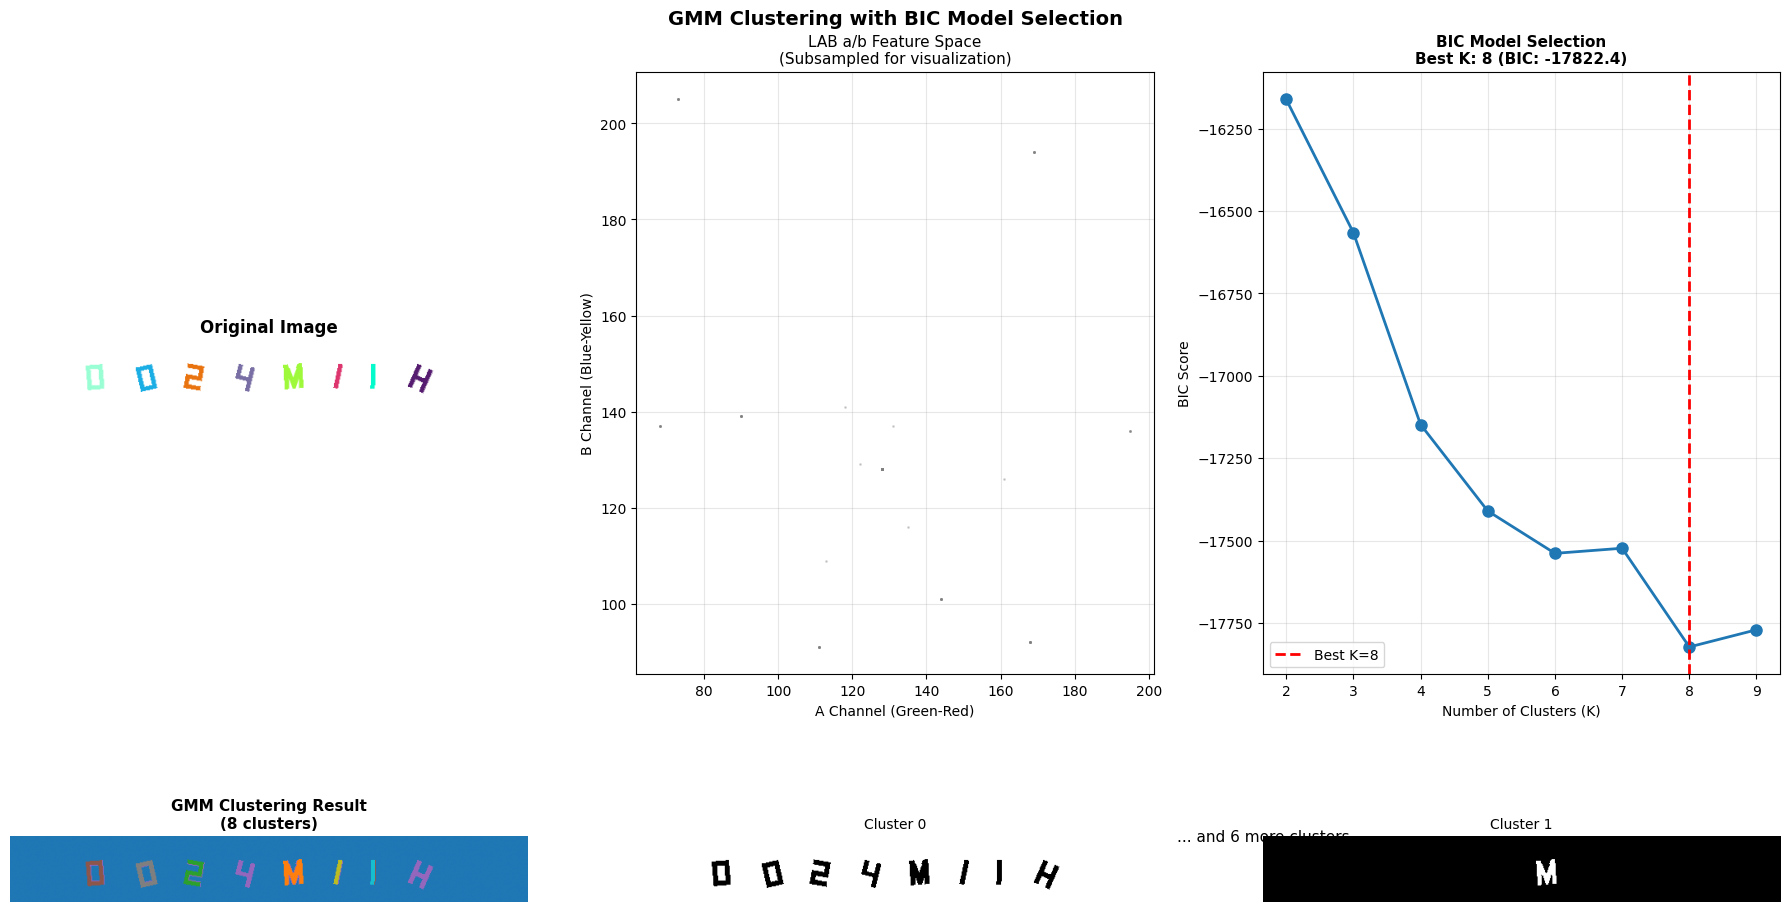

Optimal number of clusters (K): 8
BIC score: -17822.37

Example 2: 002e23-0


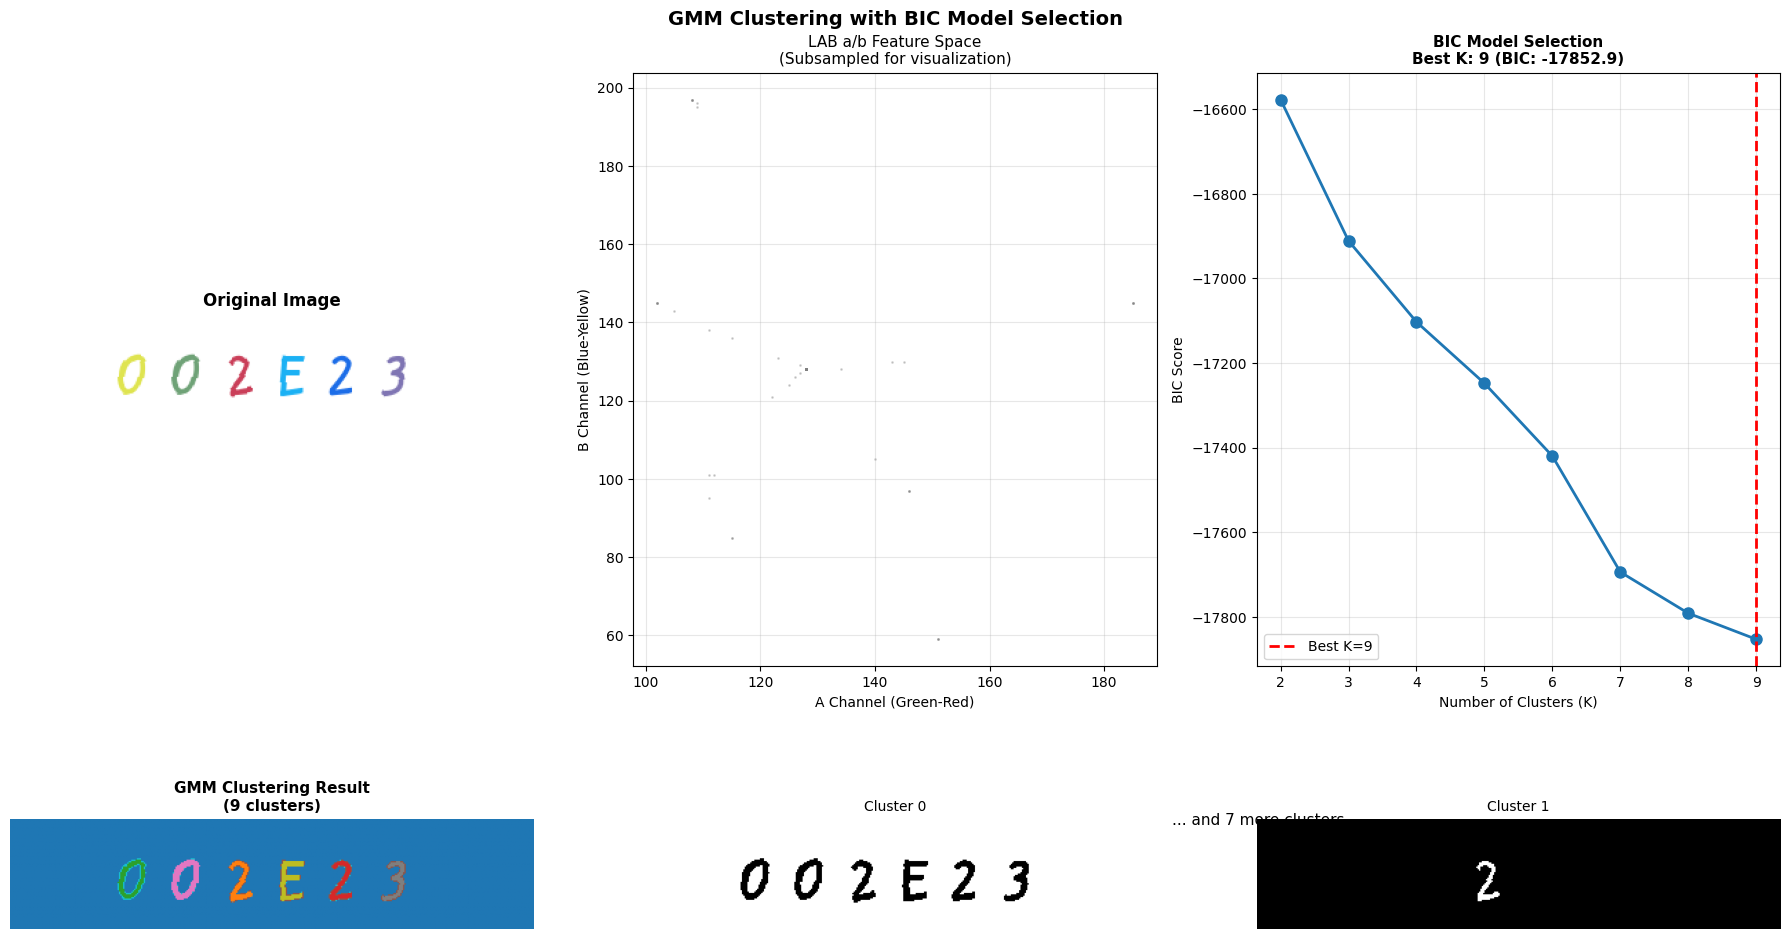

Optimal number of clusters (K): 9
BIC score: -17852.85



In [6]:
# Visualize GMM Clustering Process
def visualize_gmm_clustering(image, segmenter):
    """Visualize the GMM clustering process step by step"""
    
    # Remove black lines
    image_cleaned = segmenter.remove_black_lines(image)
    
    # Convert to LAB and extract a/b
    lab = cv2.cvtColor(image_cleaned, cv2.COLOR_BGR2LAB)
    ab = lab[:, :, 1:3].reshape(-1, 2).astype(np.float64)
    
    # Subsample for model selection
    n_pixels = ab.shape[0]
    sample = resample(ab, n_samples=min(4000, n_pixels), replace=False, random_state=42)
    
    # Scale features
    scaler = StandardScaler(with_mean=True, with_std=True)
    sample_s = scaler.fit_transform(sample)
    ab_s = scaler.transform(ab)
    
    # Test different K values and compute BIC
    k_max = min(9, n_pixels // 100)
    k_values = []
    bic_values = []
    
    for k in range(2, k_max + 1):
        try:
            gmm = GaussianMixture(
                n_components=k,
                covariance_type='full',
                reg_covar=1e-2,
                init_params='kmeans',
                n_init=3,
                max_iter=200,
                random_state=42
            )
            gmm.fit(sample_s)
            bic = gmm.bic(sample_s)
            k_values.append(k)
            bic_values.append(bic)
        except:
            continue
    
    # Find best K
    if len(bic_values) > 0:
        best_k_idx = np.argmin(bic_values)
        best_k = k_values[best_k_idx]
        best_bic = bic_values[best_k_idx]
        
        # Fit best model
        best_gmm = GaussianMixture(
            n_components=best_k,
            covariance_type='full',
            reg_covar=1e-2,
            init_params='kmeans',
            n_init=3,
            max_iter=200,
            random_state=42
        )
        best_gmm.fit(sample_s)
        labels = best_gmm.predict(ab_s).reshape(lab.shape[:2])
    else:
        best_k = 2
        labels = np.zeros(lab.shape[:2], dtype=int)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Original and feature space
    axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Plot a/b feature space (subsampled for visualization)
    sample_viz = ab[::50]  # Subsample for plotting
    axes[0, 1].scatter(sample_viz[:, 0], sample_viz[:, 1], alpha=0.3, s=1, c='gray')
    axes[0, 1].set_xlabel('A Channel (Green-Red)')
    axes[0, 1].set_ylabel('B Channel (Blue-Yellow)')
    axes[0, 1].set_title('LAB a/b Feature Space\n(Subsampled for visualization)', fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # BIC plot
    if len(k_values) > 0:
        axes[0, 2].plot(k_values, bic_values, 'o-', linewidth=2, markersize=8)
        axes[0, 2].axvline(best_k, color='red', linestyle='--', linewidth=2, label=f'Best K={best_k}')
        axes[0, 2].set_xlabel('Number of Clusters (K)')
        axes[0, 2].set_ylabel('BIC Score')
        axes[0, 2].set_title(f'BIC Model Selection\nBest K: {best_k} (BIC: {best_bic:.1f})', 
                            fontsize=11, fontweight='bold')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    else:
        axes[0, 2].text(0.5, 0.5, 'Could not compute BIC', ha='center', va='center')
        axes[0, 2].axis('off')
    
    # Row 2: Clustering results
    # Show cluster labels as colored image
    cluster_colors = plt.cm.tab10(np.linspace(0, 1, best_k))
    cluster_image = np.zeros((labels.shape[0], labels.shape[1], 3))
    for c in range(best_k):
        mask = labels == c
        cluster_image[mask] = cluster_colors[c][:3]
    
    axes[1, 0].imshow(cluster_image)
    axes[1, 0].set_title(f'GMM Clustering Result\n({best_k} clusters)', 
                        fontsize=11, fontweight='bold')
    axes[1, 0].axis('off')
    
    # Show individual clusters
    if best_k <= 4:
        for idx, c in enumerate(range(min(best_k, 3))):
            if idx < 2:
                mask = (labels == c).astype(np.uint8) * 255
                axes[1, idx+1].imshow(mask, cmap='gray')
                axes[1, idx+1].set_title(f'Cluster {c}', fontsize=10)
                axes[1, idx+1].axis('off')
    else:
        # Show first 2 clusters
        for idx in range(2):
            mask = (labels == idx).astype(np.uint8) * 255
            axes[1, idx+1].imshow(mask, cmap='gray')
            axes[1, idx+1].set_title(f'Cluster {idx}', fontsize=10)
            axes[1, idx+1].axis('off')
    
    if best_k > 3:
        axes[1, 2].text(0.5, 0.5, f'... and {best_k-2} more clusters', 
                        ha='center', va='center', fontsize=11)
        axes[1, 2].axis('off')
    
    plt.suptitle('GMM Clustering with BIC Model Selection', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print(f"Optimal number of clusters (K): {best_k}")
    print(f"BIC score: {best_bic:.2f}")
    print()

# Test on multiple samples
print("="*70)
print("TECHNIQUE 2: GMM CLUSTERING WITH BIC MODEL SELECTION")
print("="*70)
print()

for i, (img, label) in enumerate(zip(sample_images[:2], sample_labels[:2])):
    print(f"Example {i+1}: {label}")
    visualize_gmm_clustering(img, segmenter)


## Technique 3: Edge-Constrained Validation

**Problem**: Color-based clustering may include background pixels or miss character boundaries. Pure color segmentation can be noisy and may not accurately capture character edges.

**Solution**: Combine color clustering with edge detection:
- Detect edges using Canny edge detector
- Dilate edges slightly to ensure character boundaries are captured
- Combine edge mask with color cluster masks using bitwise OR
- Apply morphological operations (close/open) to refine regions

**Improvement**: Edge information anchors character boundaries, making segmentation more robust and accurate. This ensures that character strokes are properly captured even when color clustering alone might miss them.


TECHNIQUE 3: EDGE-CONSTRAINED VALIDATION

Example 1: 0024miih-0


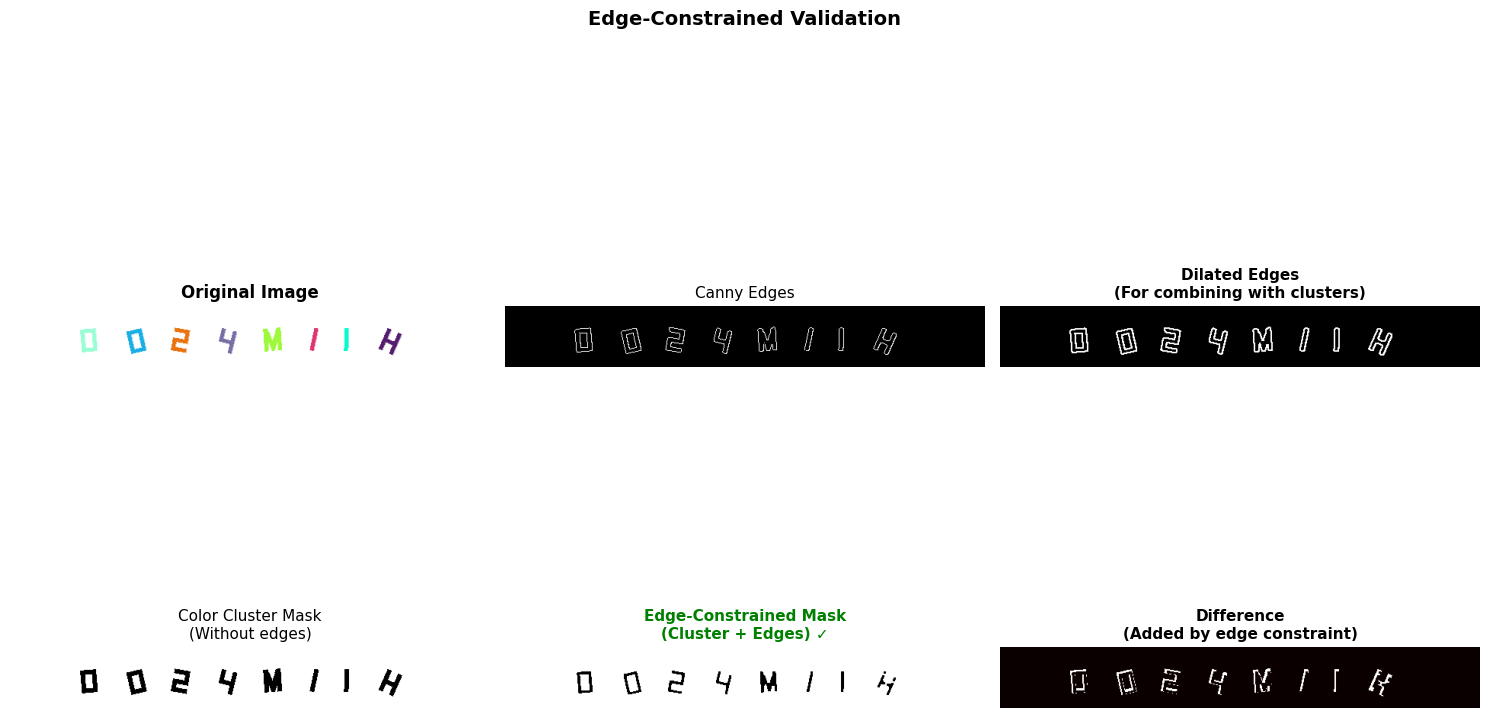

Edge pixels: 2242
Cluster pixels (without edges): 47326
Combined pixels (with edges): 48715
Edge constraint adds: 1389 pixels

Example 2: 002e23-0


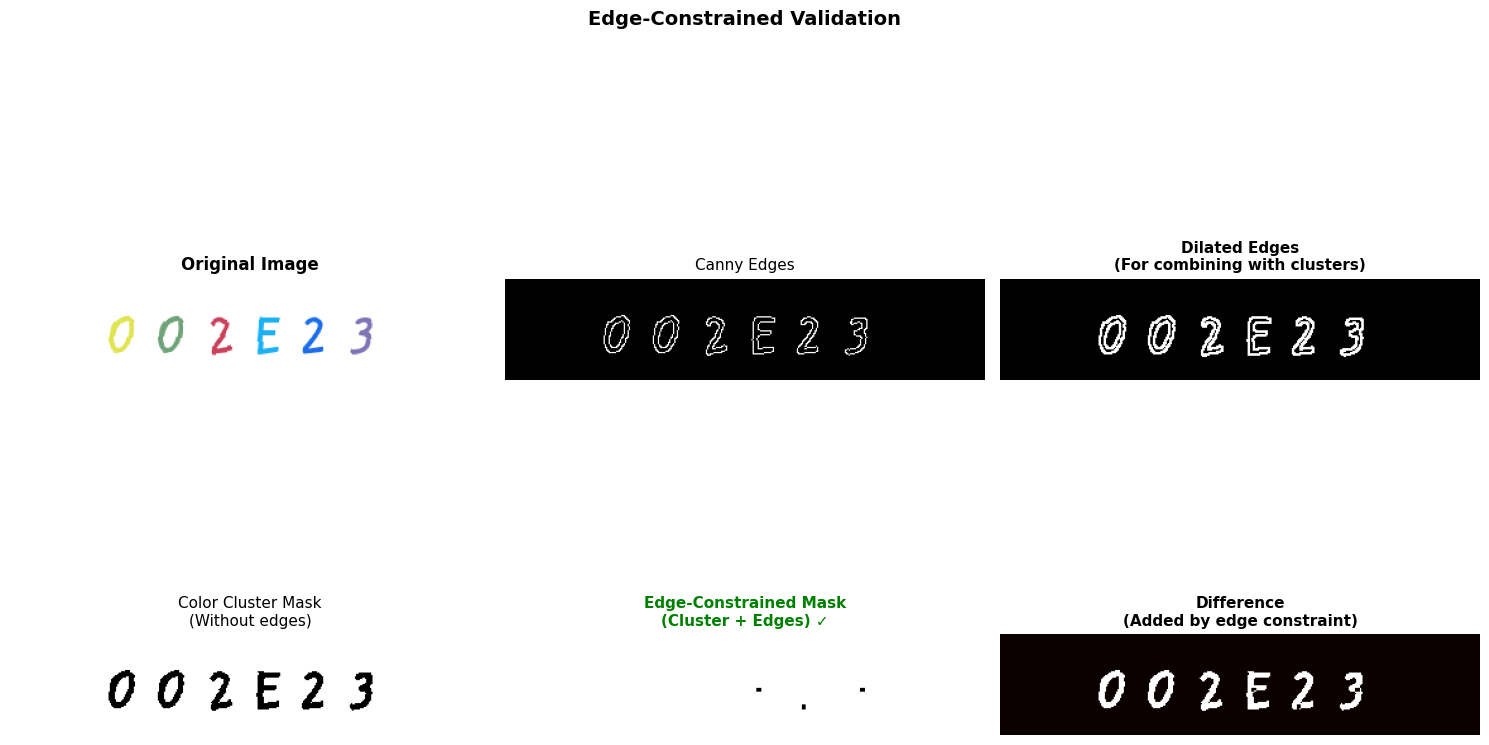

Edge pixels: 1676
Cluster pixels (without edges): 28698
Combined pixels (with edges): 30364
Edge constraint adds: 1666 pixels



In [7]:
# Visualize Edge-Constrained Validation
def visualize_edge_constrained(image, segmenter):
    """Compare color clustering with and without edge constraints"""
    
    # Get grayscale for edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 30, 100)
    edges_dilated = cv2.dilate(edges, np.ones((2, 2), np.uint8), iterations=1)
    
    # Get color clusters (simplified - just show concept)
    image_cleaned = segmenter.remove_black_lines(image)
    lab = cv2.cvtColor(image_cleaned, cv2.COLOR_BGR2LAB)
    ab = lab[:, :, 1:3].reshape(-1, 2).astype(np.float64)
    
    # Simple 3-cluster example for visualization
    sample = resample(ab, n_samples=min(4000, ab.shape[0]), replace=False, random_state=42)
    scaler = StandardScaler()
    sample_s = scaler.fit_transform(sample)
    ab_s = scaler.transform(ab)
    
    gmm = GaussianMixture(n_components=3, random_state=42, n_init=3)
    gmm.fit(sample_s)
    labels = gmm.predict(ab_s).reshape(lab.shape[:2])
    
    # Create cluster mask (example with first cluster)
    cluster_mask = (labels == 0).astype(np.uint8) * 255
    
    # Without edge constraint
    mask_no_edge = cluster_mask.copy()
    
    # With edge constraint
    mask_with_edge = cv2.bitwise_or(cluster_mask, edges_dilated)
    mask_with_edge = cv2.morphologyEx(mask_with_edge, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
    mask_with_edge = cv2.morphologyEx(mask_with_edge, cv2.MORPH_OPEN, np.ones((2, 2), np.uint8))
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Row 1: Original and edges
    axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(edges, cmap='gray')
    axes[0, 1].set_title('Canny Edges', fontsize=11)
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(edges_dilated, cmap='gray')
    axes[0, 2].set_title('Dilated Edges\n(For combining with clusters)', 
                         fontsize=11, fontweight='bold')
    axes[0, 2].axis('off')
    
    # Row 2: Cluster masks
    axes[1, 0].imshow(cluster_mask, cmap='gray')
    axes[1, 0].set_title('Color Cluster Mask\n(Without edges)', fontsize=11)
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(mask_with_edge, cmap='gray')
    axes[1, 1].set_title('Edge-Constrained Mask\n(Cluster + Edges) ✓', 
                        fontsize=11, fontweight='bold', color='green')
    axes[1, 1].axis('off')
    
    # Show difference
    diff = cv2.absdiff(mask_no_edge, mask_with_edge)
    axes[1, 2].imshow(diff, cmap='hot')
    axes[1, 2].set_title('Difference\n(Added by edge constraint)', 
                        fontsize=11, fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.suptitle('Edge-Constrained Validation', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    edge_pixels = np.sum(edges_dilated > 0)
    cluster_pixels = np.sum(cluster_mask > 0)
    combined_pixels = np.sum(mask_with_edge > 0)
    
    print(f"Edge pixels: {edge_pixels}")
    print(f"Cluster pixels (without edges): {cluster_pixels}")
    print(f"Combined pixels (with edges): {combined_pixels}")
    print(f"Edge constraint adds: {combined_pixels - cluster_pixels} pixels")
    print()

# Test on multiple samples
print("="*70)
print("TECHNIQUE 3: EDGE-CONSTRAINED VALIDATION")
print("="*70)
print()

for i, (img, label) in enumerate(zip(sample_images[:2], sample_labels[:2])):
    print(f"Example {i+1}: {label}")
    visualize_edge_constrained(img, segmenter)


## Technique 4: Color Segmentation vs Binary Fallback

**Problem**: Color segmentation works well for multi-colored CAPTCHAs but may fail for grayscale or single-color images. A robust system needs fallback mechanisms to ensure reliable performance across different CAPTCHA types.

**Solution**: Two-stage segmentation strategy:
1. **Primary**: Try color segmentation using LAB a/b + GMM clustering
2. **Fallback**: If color segmentation fails or finds no characters, use traditional binary connected components analysis

**Improvement**: Combines the strengths of color-aware segmentation with the reliability of binary methods, ensuring robust performance across different CAPTCHA types. The system automatically adapts to the image characteristics without manual intervention.


TECHNIQUE 4: COLOR SEGMENTATION VS BINARY FALLBACK

Example 1: 0024miih-0


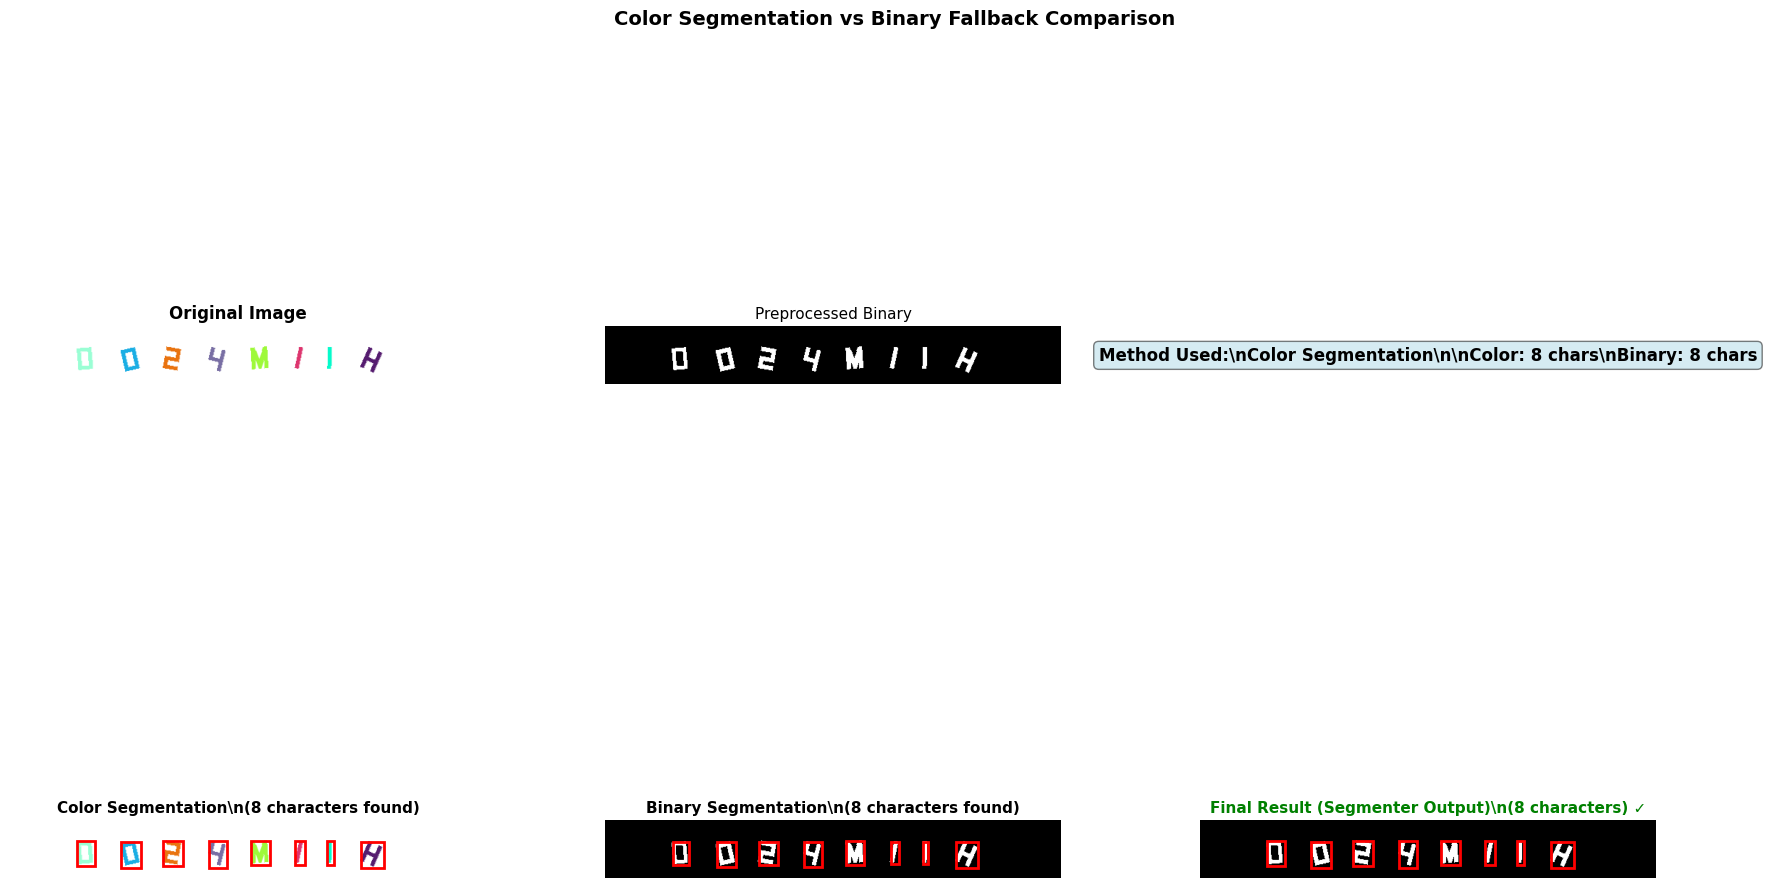

Color segmentation found: 8 characters
Binary segmentation found: 8 characters
Final result (segmenter output): 8 characters
Method used: Color Segmentation

Example 2: 002e23-0


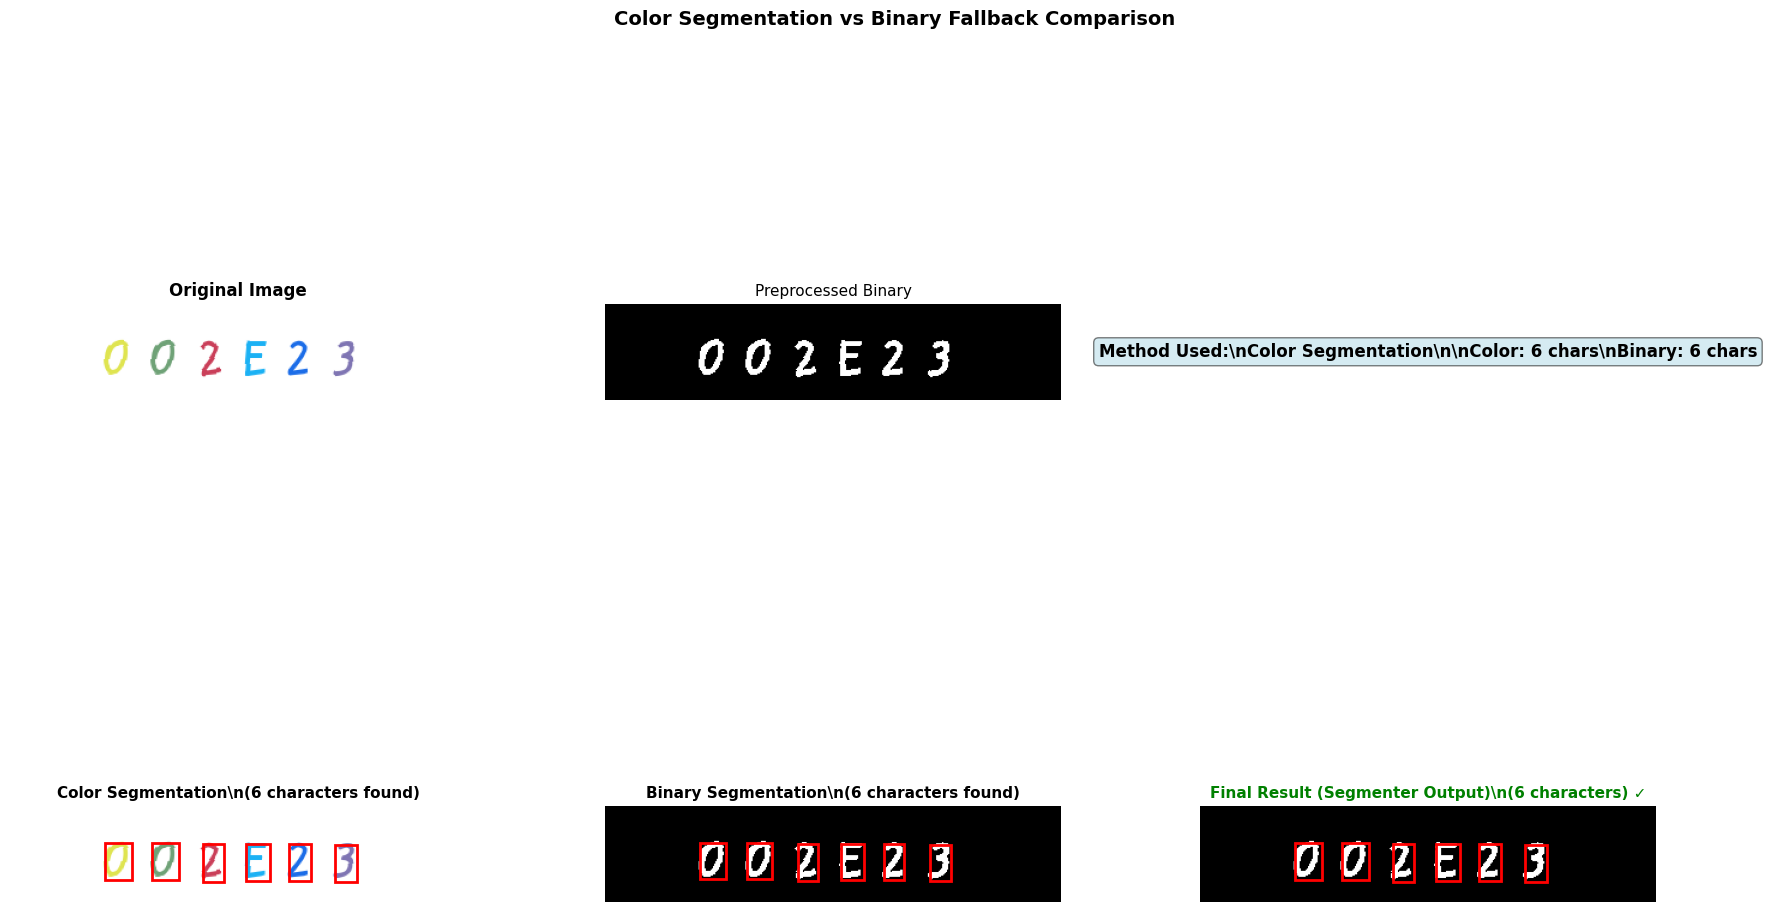

Color segmentation found: 6 characters
Binary segmentation found: 6 characters
Final result (segmenter output): 6 characters
Method used: Color Segmentation

Example 3: 002k-0


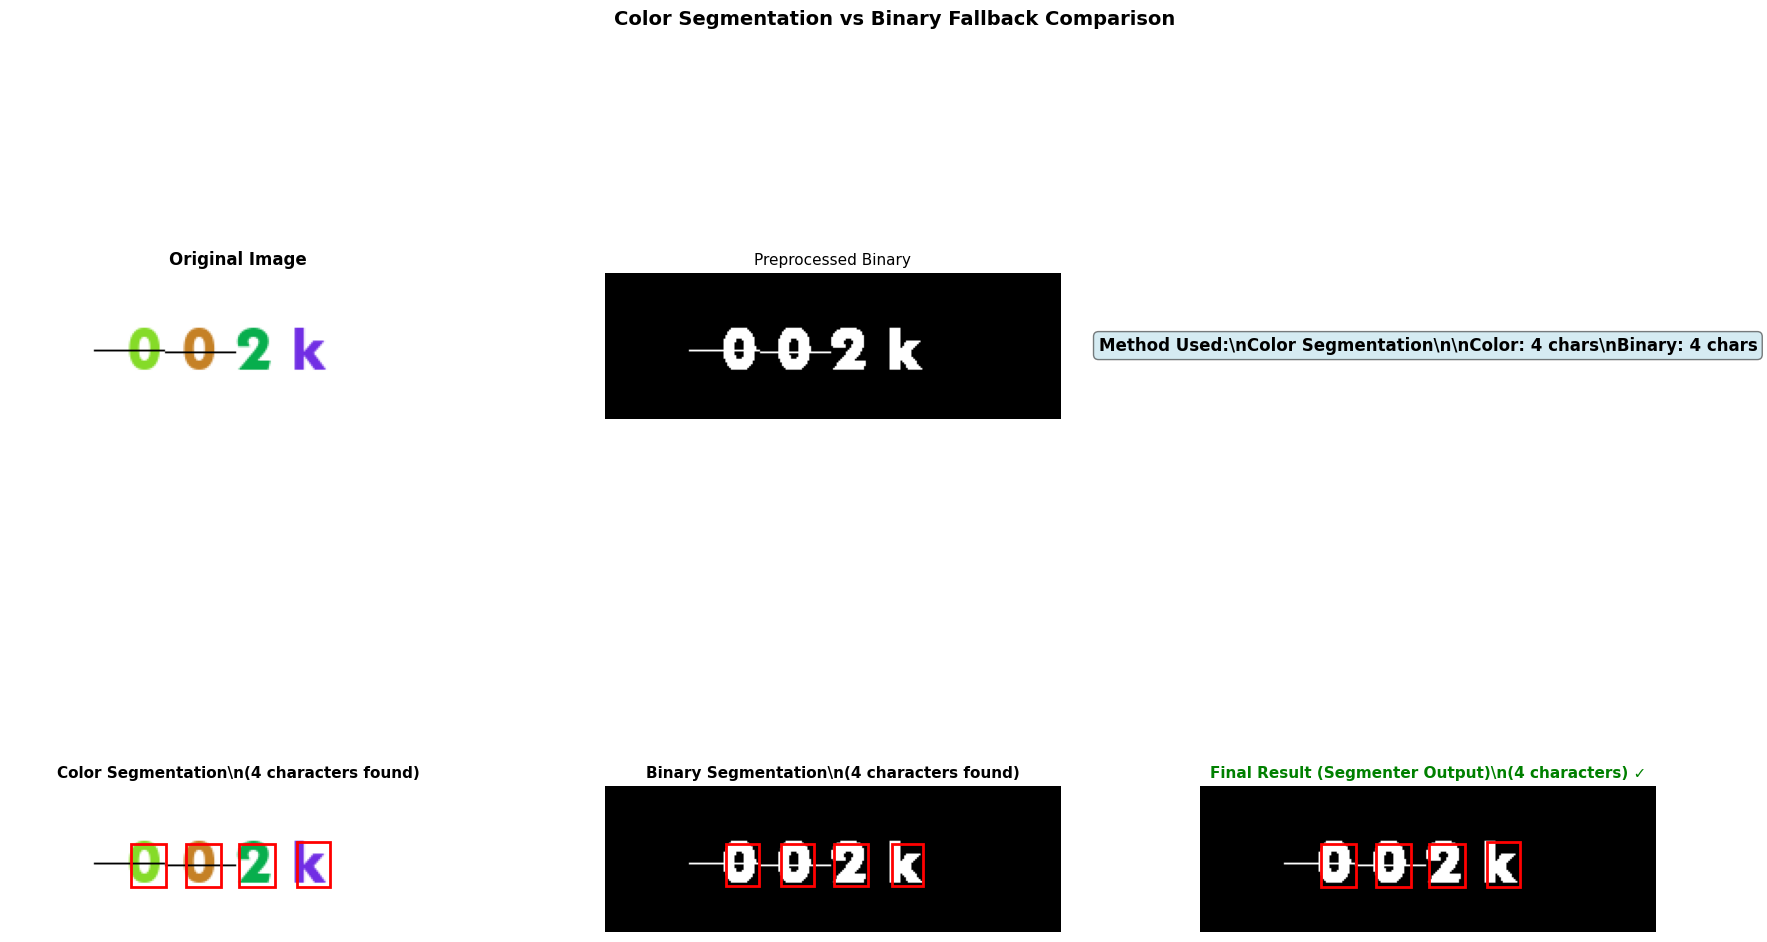

Color segmentation found: 4 characters
Binary segmentation found: 4 characters
Final result (segmenter output): 4 characters
Method used: Color Segmentation



In [11]:
# Compare Color Segmentation vs Binary Fallback
def compare_segmentation_methods(image, preprocessor, segmenter):
    """Compare color segmentation vs binary segmentation"""
    
    # Preprocess to get binary image
    binary = preprocessor.preprocess(image)
    
    # Try color segmentation
    color_boxes = segmenter._segment_by_color_lab(image, min_char_width=3, min_char_height=5)
    
    # Try binary segmentation
    cleaned = segmenter._clean_image(binary)
    binary_boxes = segmenter._find_character_regions(cleaned, min_width=3, min_height=5)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Original and binary
    axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(binary, cmap='gray')
    axes[0, 1].set_title('Preprocessed Binary', fontsize=11)
    axes[0, 1].axis('off')
    
    # Show which method was used
    method_used = 'Color Segmentation' if len(color_boxes) > 0 else 'Binary Fallback'
    axes[0, 2].text(0.5, 0.5, f'Method Used:\\n{method_used}\\n\\nColor: {len(color_boxes)} chars\\nBinary: {len(binary_boxes)} chars', 
                   ha='center', va='center', fontsize=12, fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    axes[0, 2].axis('off')
    
    # Row 2: Segmentation results
    # Color segmentation result
    axes[1, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title(f'Color Segmentation\\n({len(color_boxes)} characters found)', 
                         fontsize=11, fontweight='bold')
    for x1, y1, x2, y2 in color_boxes:
        rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, 
                        edgecolor='red', facecolor='none')
        axes[1, 0].add_patch(rect)
    axes[1, 0].axis('off')
    
    # Binary segmentation result
    axes[1, 1].imshow(binary, cmap='gray')
    axes[1, 1].set_title(f'Binary Segmentation\\n({len(binary_boxes)} characters found)', 
                         fontsize=11, fontweight='bold')
    for x1, y1, x2, y2 in binary_boxes:
        rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, 
                        edgecolor='red', facecolor='none')
        axes[1, 1].add_patch(rect)
    axes[1, 1].axis('off')
    
    # Final result (what segmenter actually returns)
    final_boxes = segmenter.segment(binary, image, min_char_width=3, min_char_height=5)
    axes[1, 2].imshow(binary, cmap='gray')
    axes[1, 2].set_title(f'Final Result (Segmenter Output)\\n({len(final_boxes)} characters) ✓', 
                         fontsize=11, fontweight='bold', color='green')
    for x1, y1, x2, y2 in final_boxes:
        rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, 
                        edgecolor='red', facecolor='none')
        axes[1, 2].add_patch(rect)
    axes[1, 2].axis('off')
    
    plt.suptitle('Color Segmentation vs Binary Fallback Comparison', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Color segmentation found: {len(color_boxes)} characters")
    print(f"Binary segmentation found: {len(binary_boxes)} characters")
    print(f"Final result (segmenter output): {len(final_boxes)} characters")
    print(f"Method used: {method_used}")
    print()

# Test on multiple samples
print("="*70)
print("TECHNIQUE 4: COLOR SEGMENTATION VS BINARY FALLBACK")
print("="*70)
print()

for i, (img, label) in enumerate(zip(sample_images[:3], sample_labels[:3])):
    print(f"Example {i+1}: {label}")
    compare_segmentation_methods(img, preprocessor, segmenter)

In [ ]:
# Visualize Complete Segmentation Pipeline
def visualize_complete_pipeline(image, preprocessor, segmenter, label=\"\"):
    \"\"\"Show the complete segmentation pipeline step-by-step\"\"\"
    
    # Step 1: Preprocess
    binary = preprocessor.preprocess(image)
    
    # Step 2: Try color segmentation
    image_cleaned = segmenter.remove_black_lines(image)
    lab = cv2.cvtColor(image_cleaned, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    
    # Get color segmentation result
    color_boxes = segmenter._segment_by_color_lab(image, min_char_width=3, min_char_height=5)
    color_success = len(color_boxes) > 0
    
    # Step 3: Get final segmentation
    final_boxes = segmenter.segment(binary, image, min_char_width=3, min_char_height=5)
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # Row 1: Input and preprocessing
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('1. Original Image', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(binary, cmap='gray')
    ax2.set_title('2. Preprocessed Binary', fontsize=12, fontweight='bold')
    ax2.axis('off')
    
    # Show LAB channels
    A_viz = ((A.astype(np.float32) - 128) / 127.0 * 255).astype(np.uint8)
    B_viz = ((B.astype(np.float32) - 128) / 127.0 * 255).astype(np.uint8)
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(A_viz, cmap='RdYlGn')
    ax3.set_title('3. LAB A Channel\n(For color clustering)', fontsize=11)
    ax3.axis('off')
    
    ax4 = fig.add_subplot(gs[0, 3])
    ax4.imshow(B_viz, cmap='YlGnBu')
    ax4.set_title('4. LAB B Channel\n(For color clustering)', fontsize=11)
    ax4.axis('off')
    
    # Row 2: Segmentation methods
    ax5 = fig.add_subplot(gs[1, 0])
    ax5.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax5.set_title(f'5a. Color Segmentation\n({len(color_boxes)} chars, {"SUCCESS" if color_success else "FAILED"})', 
                  fontsize=11, fontweight='bold', 
                  color='green' if color_success else 'orange')
    for x1, y1, x2, y2 in color_boxes:
        rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, 
                        edgecolor='red', facecolor='none')
        ax5.add_patch(rect)
    ax5.axis('off')
    
    ax6 = fig.add_subplot(gs[1, 1])
    ax6.imshow(binary, cmap='gray')
    cleaned = segmenter._clean_image(binary)
    binary_boxes = segmenter._find_character_regions(cleaned, min_width=3, min_height=5)
    ax6.set_title(f'5b. Binary Segmentation\n({len(binary_boxes)} chars)', 
                  fontsize=11, fontweight='bold')
    for x1, y1, x2, y2 in binary_boxes:
        rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, 
                        edgecolor='red', facecolor='none')
        ax6.add_patch(rect)
    ax6.axis('off')
    
    # Final result
    ax7 = fig.add_subplot(gs[1, 2])
    ax7.imshow(binary, cmap='gray')
    ax7.set_title(f'6. Final Result\n({len(final_boxes)} characters) ✓', 
                  fontsize=12, fontweight='bold', color='green')
    for x1, y1, x2, y2 in final_boxes:
        rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, 
                        edgecolor='red', facecolor='none')
        ax7.add_patch(rect)
    ax7.axis('off')
    
    # Statistics
    ax8 = fig.add_subplot(gs[1, 3])
    ax8.axis('off')
    stats_text = f"""
    SEGMENTATION STATISTICS
    
    Pipeline Steps:
    1. Preprocessing: Binary image created
    2. Color Segmentation: Attempted
    3. Binary Fallback: Used if needed
    
    Results:
    • Color segmentation: {len(color_boxes)} chars
    • Binary segmentation: {len(binary_boxes)} chars
    • Final output: {len(final_boxes)} chars
    
    Method Used:
    {'Color Segmentation' if color_success else 'Binary Fallback'}
    """
    ax8.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
             verticalalignment='center', 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    # Row 3: Comparison chart
    ax9 = fig.add_subplot(gs[2, :])
    methods = ['Color\nSegmentation', 'Binary\nSegmentation', 'Final\nOutput']
    counts = [len(color_boxes), len(binary_boxes), len(final_boxes)]
    colors = ['orange' if not color_success else 'green', 'blue', 'red']
    bars = ax9.bar(methods, counts, color=colors, alpha=0.7, 
                   edgecolor='black', linewidth=2)
    ax9.set_ylabel('Number of Characters Found', fontsize=11)
    ax9.set_title('Segmentation Method Comparison', fontsize=12, fontweight='bold')
    ax9.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, counts):
        height = bar.get_height()
        ax9.text(bar.get_x() + bar.get_width()/2., height,
                f'{val}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    if label:
        plt.suptitle(f'Complete Segmentation Pipeline - {label}', 
                     fontsize=16, fontweight='bold', y=0.98)
    else:
        plt.suptitle('Complete Segmentation Pipeline', 
                     fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'color_boxes': color_boxes,
        'binary_boxes': binary_boxes,
        'final_boxes': final_boxes,
        'color_success': color_success
    }

# Test complete pipeline on multiple examples
print("="*70)
print("COMPLETE SEGMENTATION PIPELINE: END-TO-END")
print("="*70)
print()

for i, (img, label) in enumerate(zip(sample_images[:3], sample_labels[:3])):
    print(f"\n{'='*70}")
    print(f"Example {i+1}: {label}")
    print('='*70)
    result = visualize_complete_pipeline(img, preprocessor, segmenter, label=label)
    print()


## Summary: Segmentation Techniques and Their Impact

### Technique Comparison Table

| Technique | Problem Solved | Method | Improvement |
|-----------|---------------|--------|-------------|
| **LAB Color Space** | RGB is not perceptually uniform | Use LAB a/b chroma channels | Better color-based segmentation |
| **GMM Clustering** | Need optimal number of clusters | BIC-based model selection | Automatic adaptation to image |
| **Edge Constraints** | Color clustering can be noisy | Combine with Canny edges | More accurate boundaries |
| **Binary Fallback** | Color segmentation may fail | Connected components analysis | Robust performance guarantee |

### Key Insights

1. **Color-first approach** excels for multi-colored CAPTCHAs
2. **BIC model selection** automatically adapts to different color schemes
3. **Edge constraints** improve boundary accuracy
4. **Binary fallback** ensures robustness when color segmentation fails
5. **Combined approach** provides best of both worlds: color awareness + reliability


## Complete Segmentation Pipeline: End-to-End

This section shows the complete segmentation pipeline from original image to final character bounding boxes, demonstrating how all techniques work together.
